In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# EDA

1. Общее описание данных:<br>
-  Датасет содержит 524,846 записей и 9 признаков.<br>
-  Больше __500000__ писем являются __обычными__, то есть количество __фишинговых__ писем значительно меньше, чем обычных.<br>
-  Все признаки являются числовыми, что удобно.<br> 
-  Целевая переменная __label__ отвечает за информацию, является ли письмо фишинговым __(1, если оно является)__.

In [2]:
df = pd.read_csv("email_phishing_data.csv")
df.head(3)

,num_words,num_unique_words,num_stopwords,num_links,num_unique_domains,num_email_addresses,num_spelling_errors,num_urgent_keywords,label
0,140,94,52,0,0,0,0,0,0
1,5,5,1,0,0,0,0,0,0
2,34,32,15,0,0,0,0,0,0


In [3]:
df.shape

(524846, 9)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524846 entries, 0 to 524845
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype
---  ------               --------------   -----
 0   num_words            524846 non-null  int64
 1   num_unique_words     524846 non-null  int64
 2   num_stopwords        524846 non-null  int64
 3   num_links            524846 non-null  int64
 4   num_unique_domains   524846 non-null  int64
 5   num_email_addresses  524846 non-null  int64
 6   num_spelling_errors  524846 non-null  int64
 7   num_urgent_keywords  524846 non-null  int64
 8   label                524846 non-null  int64
dtypes: int64(9)
memory usage: 36.0 MB


In [5]:
df.isnull().sum()

num_words              0
num_unique_words       0
num_stopwords          0
num_links              0
num_unique_domains     0
num_email_addresses    0
num_spelling_errors    0
num_urgent_keywords    0
label                  0
dtype: int64

In [6]:
df.label.value_counts()

label
0    517897
1      6949
Name: count, dtype: int64

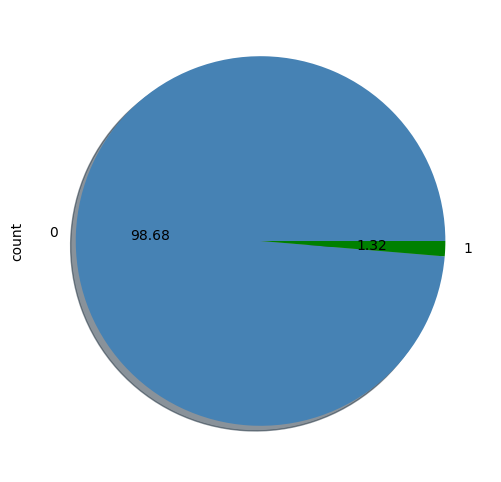

In [7]:
df['label'].value_counts().plot(kind='pie', autopct='%.2f', shadow=True, figsize=(11,6), colors=['steelblue', 'green'])
plt.show()

2. Целевая переменная. <br>
   Мы видим, что целевая переменная имеет __ОЧЕНЬ__ сильный дизбаланс между значениями 0 и 1, единиц __лишь около 1.5%__ от общего числа писем.
   <br>Это означает две вещи,
   - Во-первых, что если наша модель будет __просто предсказывать 0 ВСЕГДА__, то мы получим точность __98%__. Значит показатели точности это не единственное, на что нужно смотреть и нам надо будет также анализировать __матрицу несоответствий__.
   - Во-вторых, для тренировки и тестирования модели нам нужно использовать методы __балансировки классов__. Я буду использовать __Random Oversampling__.

In [8]:
df.num_unique_domains.value_counts()

num_unique_domains
0      431424
1       62638
2       14525
3        6421
4        3912
        ...  
88          2
33          2
123         1
524         1
46          1
Name: count, Length: 82, dtype: int64

In [9]:
numeric_columns =['num_words', 'num_unique_words', 'num_stopwords', 'num_links',
       'num_unique_domains', 'num_email_addresses', 'num_spelling_errors',
       'num_urgent_keywords']
all_columns =['num_words', 'num_unique_words', 'num_stopwords', 'num_links',
       'num_unique_domains', 'num_email_addresses', 'num_spelling_errors',
       'num_urgent_keywords', 'label']

In [10]:
df[numeric_columns].describe()

,num_words,num_unique_words,num_stopwords,num_links,num_unique_domains,num_email_addresses,num_spelling_errors,num_urgent_keywords
count,5.248460e+05,524846.000000,524846.000000,524846.000000,524846.000000,524846.000000,524846.000000,524846.000000
mean,2.762280e+02,123.012167,80.045465,0.895588,0.347767,2.114897,24.694731,0.245301
std,3.335457e+03,201.626478,1023.330380,5.603001,1.774209,13.592682,311.312358,0.559320
min,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.700000e+01,38.000000,12.000000,0.000000,0.000000,0.000000,2.000000,0.000000
50%,1.200000e+02,79.000000,34.000000,0.000000,0.000000,0.000000,8.000000,0.000000
75%,2.690000e+02,145.000000,79.000000,0.000000,0.000000,1.000000,22.000000,0.000000
max,2.339682e+06,51251.000000,720411.000000,824.000000,524.000000,1150.000000,190104.000000,7.000000


3. Уберем выбросы с помощью IQR (Interquantile Range)<br>
   У нас много данных, мы можем позволить себе удалить ту часть, где чересчур много слов или, наоборот, пустые письма. <br>
   Обращаю внимание, что делать IQR нельзя в столбцах, где 25 и 75 процентиль - нули, потому что тогда мы можем потерять важную информацию

In [11]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Список колонок, для которых применяем IQR
selected_columns = ['num_words', 'num_unique_words', 'num_stopwords', 'num_spelling_errors']

for col in selected_columns:
    df = remove_outliers_iqr(df, col)

Проверим, что мы не удалили непропорционально много фишинговых писем:

In [12]:
df.label.value_counts()

label
0    406814
1      5580
Name: count, dtype: int64

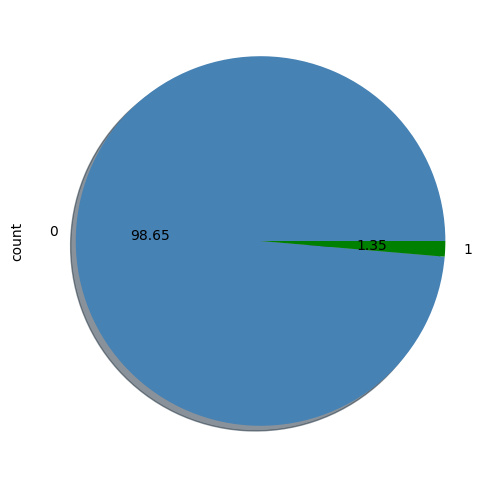

In [13]:
df['label'].value_counts().plot(kind='pie', autopct='%.2f', shadow=True, figsize=(11,6), colors=['steelblue', 'green'])
plt.show()

Порядок, мы удалили более-менее пропорциональное значение обычных и фишинговых писем.

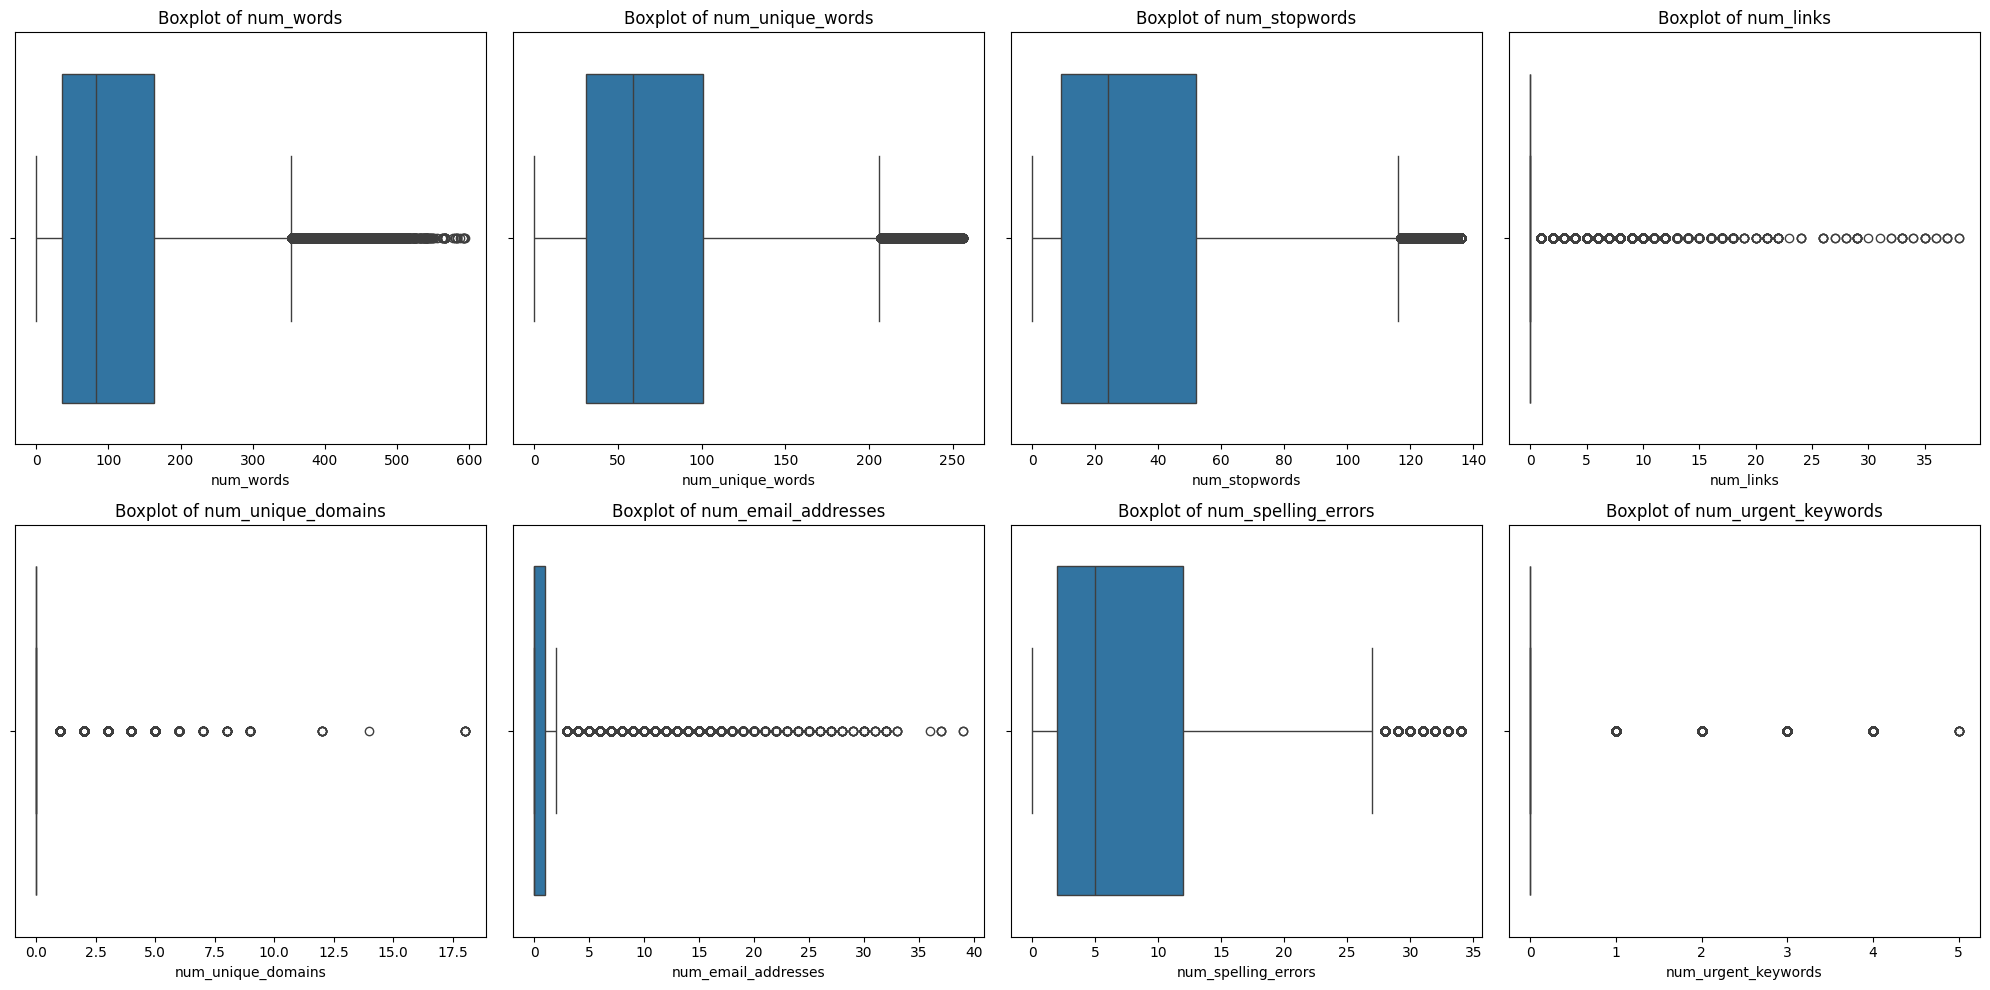

In [14]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, col in enumerate(numeric_columns):
    sns.boxplot(x=df[col], ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}', fontsize=12)

plt.tight_layout()
plt.show()

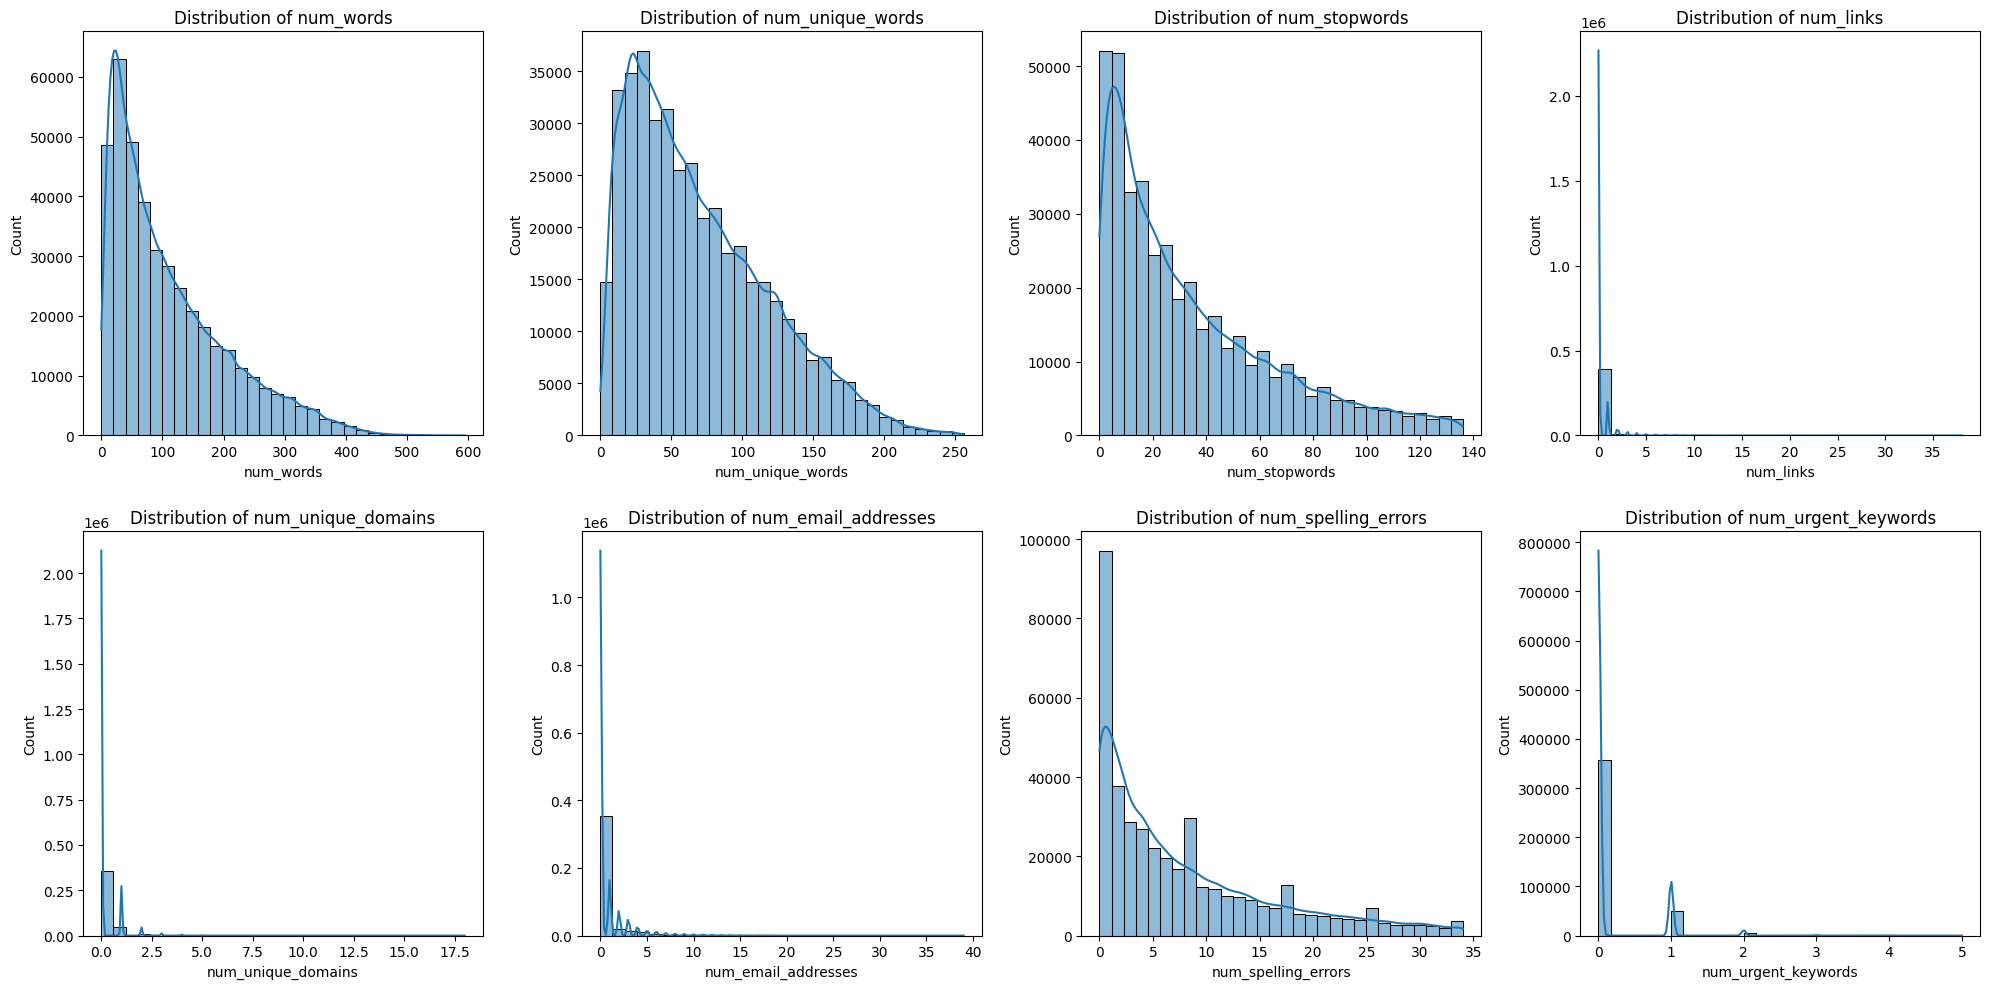

In [15]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, col in enumerate(numeric_columns):
    sns.histplot(df[col], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')

plt.tight_layout()
plt.show()



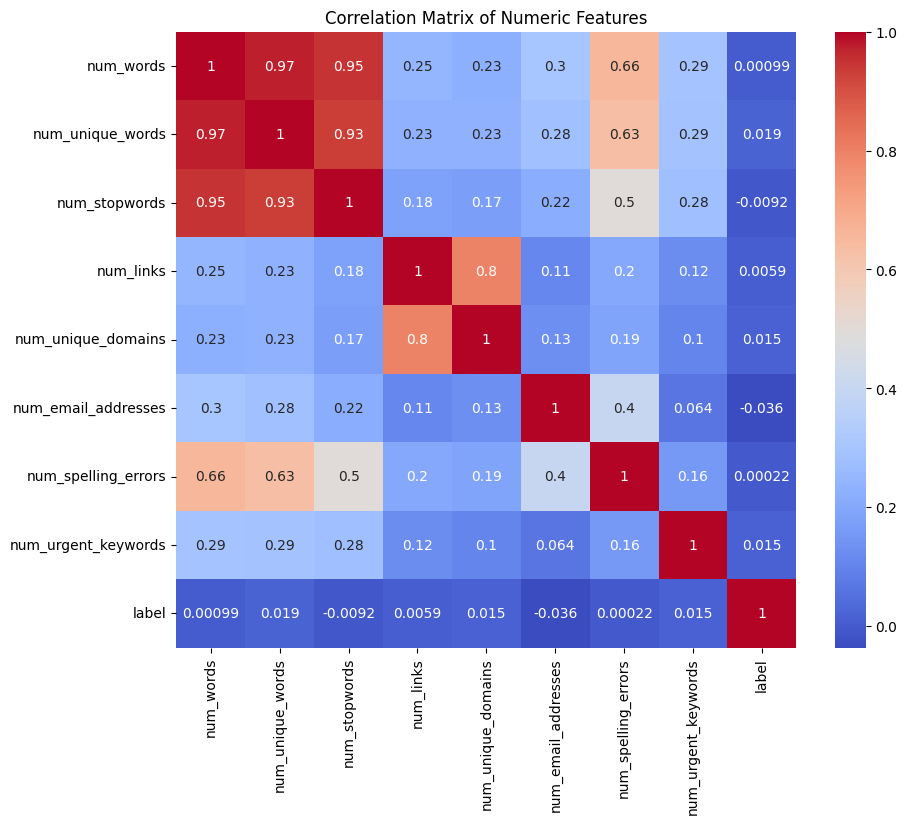

In [16]:
plt.figure(figsize=(10, 8))
sns.heatmap(df[all_columns].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numeric Features')
plt.show()

Как видно, нет какой-то удобной корреляции, которая являлась бы хорошим маркером фишинговых писем. Это печально(

In [17]:
df[numeric_columns].skew().sort_values(ascending=False)
#Довольно очевидные значения, учитывая что у всех наших графиков длинный хвост вправо...

num_links              8.981282
num_email_addresses    5.035540
num_unique_domains     4.964467
num_urgent_keywords    2.938872
num_spelling_errors    1.216238
num_stopwords          1.145994
num_words              1.137879
num_unique_words       0.832978
dtype: float64

# Моделирование

Как уже было упомянуто, нам нельзя просто обучать модель на данных as is, потому что из-за большой непропорциональности, модель будет иметь высокую точность ~98%, даже если будет предсказывать 0 всегда. Поэтому сперва сделаем апсемплинг.

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
from xgboost import XGBClassifier
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

X = df.drop('label', axis=1)
y = df['label']

# Разделение групп
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 1. Random Oversampling
# Разделим меньшинство и большинство
df_majority = df[df['label'] == 0]
df_minority = df[df['label'] == 1]

# Апсемплим меньшинство
df_minority_upsampled = resample(df_minority, 
                                 replace=True,    
                                 n_samples=len(df_majority), 
                                 random_state=42)

# Совместим большинство и апсемпленное меньшинство
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Перемешаем датафрейм
df_upsampled = df_upsampled.sample(frac=1, random_state=42).reset_index(drop=True)

# Разделим таргет и фичурс
X_train_upsampled = df_upsampled.drop('label', axis=1)
y_train_upsampled = df_upsampled['label']

# 2. Масштабируем данные
scaler = StandardScaler()

# Трансформируем оба сета
X_train_scaled = scaler.fit_transform(X_train_upsampled)
X_test_scaled = scaler.transform(X_test)

Я использую и сравню 4 модели: __Logistic Regression__, __Random Forest__, __Decision Tree__ и __XGBoost__

In [19]:
import time

models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', random_state=42),
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced', random_state=42),
    'XGBoost': XGBClassifier(scale_pos_weight=10, random_state=42)
}
for model_name, model in models.items():
    print(f'\nTraining {model_name}...')
    start_time = time.time()
    # Обучение модели
    model.fit(X_train_scaled, y_train_upsampled)
    end_time = time.time()

    # Делаем предсказание на кофейной гуще
    y_pred = model.predict(X_test_scaled)
    elapsed_time = end_time - start_time

    # Оцениваем производительность
    print(f"{model_name} training completed in {elapsed_time:.2f} seconds.")
    print(f'Performance of {model_name}:')
    print(classification_report(y_test, y_pred))
    print(f'Accuracy: {accuracy_score(y_test, y_pred)}\n')




Training Logistic Regression...
Logistic Regression training completed in 3.01 seconds.
Performance of Logistic Regression:
              precision    recall  f1-score   support

           0       0.99      0.70      0.82    122097
           1       0.03      0.70      0.06      1622

    accuracy                           0.70    123719
   macro avg       0.51      0.70      0.44    123719
weighted avg       0.98      0.70      0.81    123719

Accuracy: 0.7033519507917135


Training Random Forest...
Random Forest training completed in 112.20 seconds.
Performance of Random Forest:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    122097
           1       0.45      0.98      0.62      1622

    accuracy                           0.98    123719
   macro avg       0.73      0.98      0.81    123719
weighted avg       0.99      0.98      0.99    123719

Accuracy: 0.9843193042297465


Training Decision Tree...
Decision Tree training co

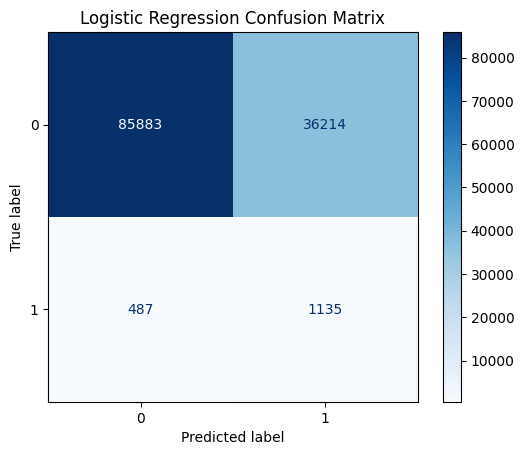

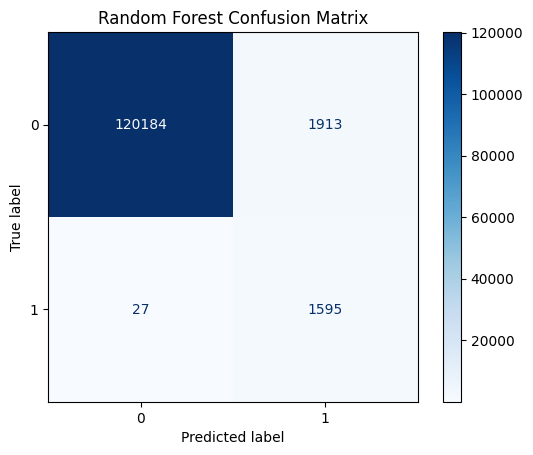

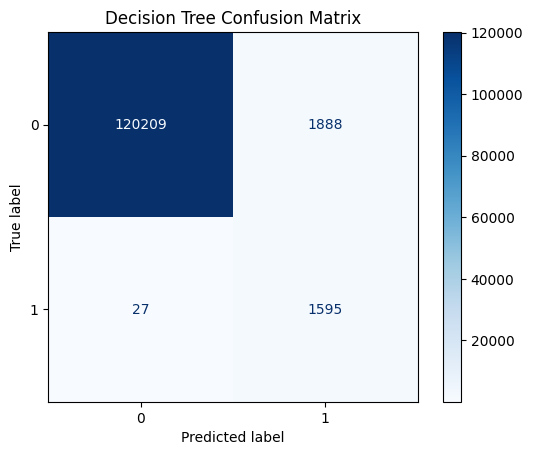

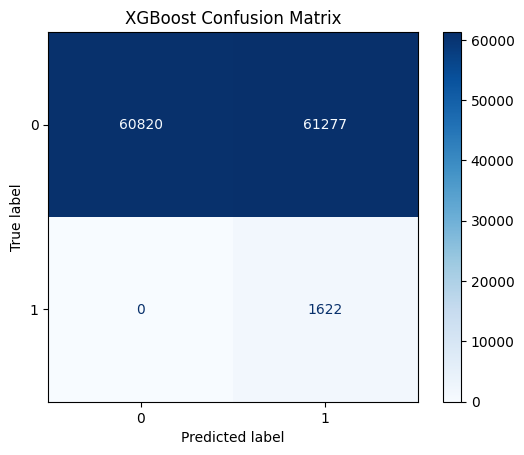

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

for model_name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

# Вывод

- Как видим из информации о производительности и матриц несоответствий, несмотря на примерно одинаковое и довольно неплохое количество верно предсказанных фишинговых писем у всех трех моделей, логистическая регрессия и XGBoost __очень__ часто называют фишинговыми обычные письма.
- Случайный лес и дерево решений же не только точно предсказывают фишинговые письма, но и не очень часто помечает обычные письма как фишинговые, что очень хорошо
- В силу того что Случайный Лес __намного__ медленнее Дерева Решений, а результаты дает почти идентичные, Дерево Решений является __лучшим__ методом для предсказания в нашем случае.
- В случае XGBoost такое большое количество ошибок на фоне Случайного Леса не очень понятно. Предполагаю, что если правильно подобрать гиперпараметры и по-другому обработать данные, то можно добиться высокой точности и от него

Несмотря на то что можно было добиться схожей точности просто выставляя письму 0 __всегда__, я добился того чтобы модель раскрывала фишинговые письма в БОЛЬШЕЙ части случаев методом Случайного Леса и Дерева Решений, ценой того что некоторые невиновные письма были помечены как фишинг.